In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#install efficientnet, as not available in tf.keras
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-cq63srkn
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-cq63srkn
     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=de79c9de11cfa50ef46966add06d9150119fc45c4b05720e0f3b228b917a1cc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-3__qk2c2/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from functools import partial
from sklearn.model_selection import train_test_split
import re
import efficientnet.keras as efn
import random

In [4]:
#TPU detection
print(tf.__version__)
#version 2.2.0 when TPU connected
# TF 2.2 version
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)


2.2.0
Number of accelerators:  8


In [5]:
#variable setup
AUTOTUNE = tf.data.experimental.AUTOTUNE #autotunes data transfer to optimize efficiency
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16*strategy.num_replicas_in_sync
# larger BATCH_SIZE results in out of memory error
# I believe this is an 8 core TPU, therefore batch_size = 128, batches of size that are a power of 128 work best
IMAGE_SIZE = [512,512]
CLASSES = ["1", "2", "3", "4", "5"] #4 disease classes and healthy class
EPOCHS = 30 #for now, will also implement early stopping so maybe this will not be relevant
print(GCS_PATH)

gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e


In [6]:
#load data

#decode data 
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)/255.0
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    return img
#read tfrecords
def read_tfrecord(example, labeled):
    if labeled:
        TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string), #[] is the shape (is just single value)
            "target": tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "image_name": tf.io.FixedLenFeature([], tf.string)
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    img = decode_img(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return(img, label)
    else:
        idNum = example["image_name"]
        return(img, idNum)
#load dataset
def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #disable order == increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTOTUNE) #automatically interleaves reads from multiple files
    dataset.with_options(ignore_order) #use data as it streams in
    dataset = dataset.map(partial(read_tfrecord, labeled = labeled), num_parallel_calls = AUTOTUNE)
    return dataset

In [7]:
#data augmentation
#my data augmentation screws with predictions... --> validation accuracy higher than training accuracy
def data_augment(img, label):
    #perhaps use this https://keras.io/api/preprocessing/image/  --> ImageDataGenerator
    #test ^ function on 1 example to see input and output shapes
    tf.image.random_flip_left_right(img)
    tf.image.random_flip_up_down(img)
    if random.randint(0,100)>=35:
        tf.image.transpose(img)
    #add rotation
    if random.randint(0,100)>=35:
        tf.image.rot90(img, random.choice([1,3]))
    if random.randint(0,100)>=35:
        tf.image.random_brightness(img, max_delta = 0.3)
    if random.randint(0,100)>=35:
        tf.image.random_contrast(img, lower = 0.7, upper = 1.3)
    if random.randint(0,100)>=35:
        tf.image.random_saturation(img, lower = 0.7, upper = 1.3)
    if random.randint(0,100)>=35:
        tf.image.random_hue(img,max_delta = 0.15)
    if random.randint(0,100)>=35:
        tf.image.random_jpeg_quality(img, 25, 100)

    #care, some data augmentation will NOT work with TPU
    #can add crop (or shift), etc maybe
    return img, label
def take_center(img, label):
    return img, label

In [8]:
#split, look into using cross validation instead of test train split
TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH+"/train_tfrecords/ld_train*.tfrec"),
    test_size = 0.2)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH+"/test_tfrecords/ld_test*.tfrec")

In [9]:
#loading data

def get_train_data():
    dataset = load_dataset(filenames = TRAIN_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTOTUNE)
    dataset = dataset.repeat() #repeats dataset, maybe can put before data augmentation
    dataset = dataset.shuffle(2048) #shuffles dataset, 2048 is the buffer size > batch size
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) #creates a dataset that automatically prefetches data from this dataset... maybe acts like some kind of generator object or something
    return dataset

def get_valid_data(ordered = False):
    dataset = load_dataset(filenames = VALID_FILENAMES, labeled = True)
    #try this next line (resize to fit efficientnetB5)
    #dataset = dataset.map(take_center, num_parallel_calls = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() #remembers this dataset
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_data(ordered = False): #for outputting actual test data, will need to specify ordered = True
    dataset = load_dataset(filenames = TEST_FILENAMES, labeled = False, ordered = ordered)
    #try this next line (resize to fit efficientnetB5)
    #dataset = dataset.map(take_center, num_parallel_calls = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [10]:
#some dataset parameter stuff
def dataset_sizes(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return(np.sum(n))
NUM_TRAINING_IMAGES = dataset_sizes(TRAIN_FILENAMES)
NUM_VALIDATION_IMAGES = dataset_sizes(VALID_FILENAMES)
NUM_TEST_IMAGES = dataset_sizes(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


In [11]:
#possible dataset exploration here

In [12]:
#building model

#define parameters
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-3,
    decay_steps=50000,
    decay_rate=0.95,
)
#try stochastic gradient descent with warm restarts
def scheduler_lr_1(epoch):
    if epoch < 22:
        return(5e-5+1e-3*(1+np.cos(np.pi*epoch/7))*(1-epoch/30))
    elif epoch < 28:
        return(1e-5)
    elif epoch < 34:
        return(1e-6)
    else:
        return(1e-7)#maybe unnecessary or worse
    
lr_schedule1 = tf.keras.callbacks.LearningRateScheduler(scheduler_lr_1)

#model
with strategy.scope():
    #img_adjust_layer = tf.keras.layers.Lambda(
    #    #tf.keras.applications.xception.preprocess_input, input_shape = [*IMAGE_SIZE, 3]
    #    efn.preprocess_input#, input_shape = [*IMAGE_SIZE, 3]
    #)
    base_model = efn.EfficientNetB5(include_top = False, weights = "imagenet", input_shape = (*IMAGE_SIZE, 3))
    base_model.trainable = False
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm = True),
        #img_adjust_layer, #idk how to use preprocess_input
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(), #may swap this out for dense layers
        tf.keras.layers.Dropout(0.1), #dropout of 0.05 works incrementally better... this does not get rid of overfitting when training whole model
        tf.keras.layers.Dense(len(CLASSES), activation = "softmax"),
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),#learning_rate = lr_schedule),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )


115515392/115515256 [==============================] - 1s 0us/step


In [13]:
#train model
#load data
train_data = get_train_data()
valid_data = get_valid_data()

#other parameters
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE #pretty sure this should not be a floor calculation (ie should round up) 
#steps_per_epoch = int( np.ceil(x_train.shape[0] / batch_size) ) -> using floor will have missing data that does not go in
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

print(BATCH_SIZE)
print(STEPS_PER_EPOCH)
print(VALID_STEPS)


128
125
41


In [14]:
#maybe add early stop too
history = model.fit(train_data, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=40,#EPOCHS,
                    validation_data=valid_data,
                    validation_steps=VALID_STEPS,
                    callbacks = [lr_schedule1])

Epoch 1/40
125/125 [==============================] - 72s 578ms/step - sparse_categorical_accuracy: 0.6904 - loss: 0.8332 - val_sparse_categorical_accuracy: 0.7611 - val_loss: 0.6548 - lr: 0.0021
Epoch 2/40
125/125 [==============================] - 42s 340ms/step - sparse_categorical_accuracy: 0.7516 - loss: 0.6739 - val_sparse_categorical_accuracy: 0.7811 - val_loss: 0.6101 - lr: 0.0019
Epoch 3/40
125/125 [==============================] - 42s 339ms/step - sparse_categorical_accuracy: 0.7654 - loss: 0.6420 - val_sparse_categorical_accuracy: 0.7864 - val_loss: 0.5867 - lr: 0.0016
Epoch 4/40
125/125 [==============================] - 42s 338ms/step - sparse_categorical_accuracy: 0.7741 - loss: 0.6234 - val_sparse_categorical_accuracy: 0.7938 - val_loss: 0.5739 - lr: 0.0012
Epoch 5/40
125/125 [==============================] - 43s 342ms/step - sparse_categorical_accuracy: 0.7746 - loss: 0.6191 - val_sparse_categorical_accuracy: 0.7967 - val_loss: 0.5747 - lr: 7.2382e-04
Epoch 6/40
125/1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  21        
_________________________________________________________________
efficientnet-b5 (Model)      (None, 16, 16, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10245     
Total params: 28,523,786
Trainable params: 10,251
Non-trainable params: 28,513,535
_________________________________________________________________
None


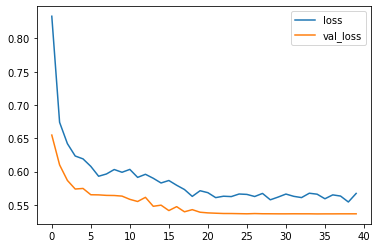

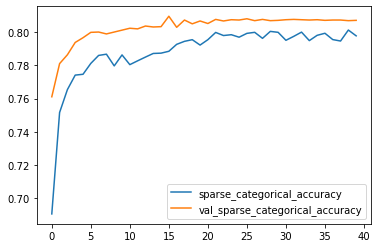

In [15]:
print(model.summary())
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [16]:
#make top few layers in base model trainable, then train on dataset again
#make all layers trainable
for layer in model.layers:
    layer.trainable = True
    
#l2 regularization #https://stackoverflow.com/questions/48330137/adding-regularizer-to-an-existing-layer-of-a-trained-model-without-resetting-wei
l2 = tf.keras.regularizers.l2(1e-4)
#1e-4 works better 1e-5, also seems to work better than 1e-3
for layer in model.layers[1].layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = l2

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  21        
_________________________________________________________________
efficientnet-b5 (Model)      (None, 16, 16, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10245     
Total params: 28,523,786
Trainable params: 28,351,035
Non-trainable params: 172,751
_________________________________________________________________
None


In [17]:
#define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    #monitor = "val_sparse_categorical_accuracy",
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),# epsilon = 1e-7 is default already
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [early_stop],#, lr_schedule1], #lr_schedule1 is not a good fit (initial decrease is good, but increasing again is a mistake)
                     #likely should use early stopping too... also reducing the l2 cost seems to make overfitting an increasing issue
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)

Epoch 1/30
125/125 [==============================] - 97s 779ms/step - sparse_categorical_accuracy: 0.8055 - loss: 0.5677 - val_sparse_categorical_accuracy: 0.8472 - val_loss: 0.5598
Epoch 2/30
125/125 [==============================] - 79s 629ms/step - sparse_categorical_accuracy: 0.8696 - loss: 0.3770 - val_sparse_categorical_accuracy: 0.8739 - val_loss: 0.4155
Epoch 3/30
125/125 [==============================] - 75s 603ms/step - sparse_categorical_accuracy: 0.8946 - loss: 0.3077 - val_sparse_categorical_accuracy: 0.8443 - val_loss: 0.5237
Epoch 4/30
125/125 [==============================] - 76s 604ms/step - sparse_categorical_accuracy: 0.9228 - loss: 0.2268 - val_sparse_categorical_accuracy: 0.8476 - val_loss: 0.5830
Epoch 5/30
125/125 [==============================] - 76s 604ms/step - sparse_categorical_accuracy: 0.9296 - loss: 0.2060 - val_sparse_categorical_accuracy: 0.8603 - val_loss: 0.4986
Epoch 6/30
125/125 [==============================] - 76s 604ms/step - sparse_categor

In [18]:
#redefine early stop
#define new early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_sparse_categorical_accuracy",
    min_delta = 0.0005,
    patience = 5,
    restore_best_weights = True,
)

with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2_2 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [early_stop],
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)


Epoch 1/30
125/125 [==============================] - 98s 783ms/step - sparse_categorical_accuracy: 0.9201 - loss: 0.2440 - val_sparse_categorical_accuracy: 0.8847 - val_loss: 0.3666
Epoch 2/30
125/125 [==============================] - 75s 603ms/step - sparse_categorical_accuracy: 0.9244 - loss: 0.2253 - val_sparse_categorical_accuracy: 0.8845 - val_loss: 0.3626
Epoch 3/30
125/125 [==============================] - 78s 625ms/step - sparse_categorical_accuracy: 0.9303 - loss: 0.2047 - val_sparse_categorical_accuracy: 0.8857 - val_loss: 0.3643
Epoch 4/30
125/125 [==============================] - 75s 602ms/step - sparse_categorical_accuracy: 0.9348 - loss: 0.1923 - val_sparse_categorical_accuracy: 0.8857 - val_loss: 0.3671
Epoch 5/30
125/125 [==============================] - 78s 626ms/step - sparse_categorical_accuracy: 0.9373 - loss: 0.1838 - val_sparse_categorical_accuracy: 0.8862 - val_loss: 0.3683
Epoch 6/30
125/125 [==============================] - 75s 602ms/step - sparse_categor

In [19]:
with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-7),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2_3 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [early_stop],
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)

model.save('EfficientNetB5_based.h5')

Epoch 1/30
125/125 [==============================] - 97s 779ms/step - sparse_categorical_accuracy: 0.9411 - loss: 0.1682 - val_sparse_categorical_accuracy: 0.8862 - val_loss: 0.3766
Epoch 2/30
125/125 [==============================] - 76s 606ms/step - sparse_categorical_accuracy: 0.9441 - loss: 0.1622 - val_sparse_categorical_accuracy: 0.8861 - val_loss: 0.3768
Epoch 3/30
125/125 [==============================] - 75s 603ms/step - sparse_categorical_accuracy: 0.9461 - loss: 0.1628 - val_sparse_categorical_accuracy: 0.8862 - val_loss: 0.3771
Epoch 4/30
125/125 [==============================] - 75s 603ms/step - sparse_categorical_accuracy: 0.9449 - loss: 0.1609 - val_sparse_categorical_accuracy: 0.8861 - val_loss: 0.3773
Epoch 5/30
125/125 [==============================] - 76s 607ms/step - sparse_categorical_accuracy: 0.9442 - loss: 0.1634 - val_sparse_categorical_accuracy: 0.8862 - val_loss: 0.3770
Epoch 6/30
125/125 [==============================] - 80s 644ms/step - sparse_categor

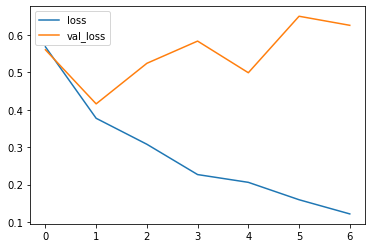

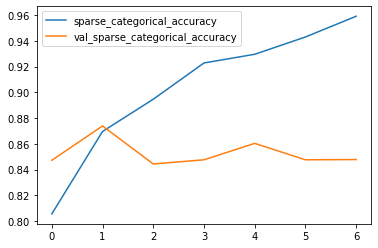

In [20]:
#append new data onto history_df to see full training graph
history_df2 = pd.DataFrame(history2.history) 
history_df2.loc[:, ['loss', 'val_loss']].plot() 
history_df2.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

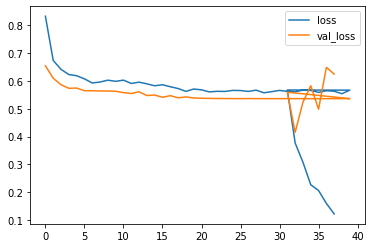

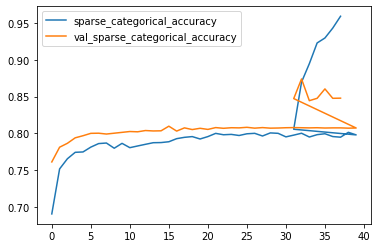

In [21]:
history_df2.index = range(31,31+len(history_df2.index))

total_history_df = pd.concat([history_df, history_df2])
total_history_df.loc[:, ['loss', 'val_loss']].plot()
total_history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()